Hessianの解体を試みる。

In [2]:
%%time
import numpy as np
import math
# TIP4Pの座標系
angle,holen,colen = 104.52,0.9572,0.15
wh = 1.0
wo = 16.0
wm = wh + wh + wo
rangle = angle*math.pi/360
ohz=holen*math.cos(rangle)
hyl=holen*math.sin(rangle)
hzl=wo*ohz/wm
ol=-ohz+hzl
cl=colen+ol
# 分子内の原子位置
intra = np.array([[0,hyl,hzl],
                  [0,-hyl,hzl],
                  [0,0,ol],
                  [0,0,cl]]).T
# 分子内座標の、軸を交換したもの
intra2 = np.zeros_like(intra)
intra2[0] = intra[1]
intra2[1] = intra[2]
intra2[2] = intra[0]

# 2分子の座標を読みこむ。
file = open("test.nx3a")
# file = open("1234.0.nx3a")
while True:
    line = file.readline()
    if len(line) == 0:
        break
    if "@NX3A" in line:
        line = file.readline()
        nmol = int(line)
        pos = []
        for i in range(nmol):
            line = file.readline()
            pos.append([float(x) for x in line.split()])
        pos = np.array(pos)
    if "@BOX3" in line:
        line = file.readline()
        cell = np.diag(np.array([float(x) for x in line.split()]))
        celli = np.linalg.inv(cell)

lc = [0 for i in range(nmol)]
        
from sympy import *

# おまじない
init_printing()

a,b,c=symbols('a b c')

B = Matrix([[ cos(c),-sin(c),0],
            [ sin(c), cos(c),0],
            [0,0,1]])
C = Matrix([[1,0,0],
            [0, cos(a),-sin(a)],
            [0, sin(a), cos(a)]])
D = Matrix([[ cos(b),-sin(b),0],
            [ sin(b), cos(b),0],
            [0,0,1]])
AI = D*C*B


# 解析的に回転行列を角度で微分し、それをpythonの関数とする。
A1 = lambdify([a,b,c],AI)
A1a = lambdify([a,b,c],diff(AI,a))
A1b = lambdify([a,b,c],diff(AI,b))
A1c = lambdify([a,b,c],diff(AI,c))
A1aa = lambdify([a,b,c],diff(AI,a,a))
A1bb = lambdify([a,b,c],diff(AI,b,b))
A1cc = lambdify([a,b,c],diff(AI,c,c))
A1ab = lambdify([a,b,c],diff(AI,a,b))
A1bc = lambdify([a,b,c],diff(AI,b,c))
A1ca = lambdify([a,b,c],diff(AI,c,a))



def conv_euler(ea,eb,ec):
    sina=math.sin(ea)
    sinb=math.sin(eb)
    sinc=math.sin(ec)
    cosa=math.cos(ea)
    cosb=math.cos(eb)
    cosc=math.cos(ec)

    ap = math.acos(sina*sinc)
    cp = math.atan2(sina*cosc, cosa)
    bp = math.atan2(-sinb*sinc*cosa+cosb*cosc, -sinb*cosc-sinc*cosa*cosb)
    return ap,bp,cp


#for i in range(nmol):
#    for j in range(i):
#        print("distance {0}-{1}".format(i,j))
#        print(np.linalg.norm(pos[i][0:3]-pos[j][0:3]))

# 回転行列に分子内座標をかけたもの。原子の重心からの空間座標
D0 = np.zeros([nmol,3,4])
# 回転行列の、角度による一階微分に、分子内座標をかけたもの。
# D1 == dR_i / da_i
D1 = np.zeros([nmol,3,3,4]) # molecule, euler angle, vectors, sites
# 回転行列の、角度による二階微分に、分子内座標をかけたもの。
# D2 == d^2 R_i / da db
D2 = np.zeros([nmol,3,3,3,4]) # molecule, euler angle1, angle2, vectors, sites

for i in range(nmol):
    ea,eb,ec = pos[i][3:6]
    # print("criteria", abs(math.sin(ea)))
    if abs(math.sin(ea)) > 0.0:
        D0[i] = A1(ea,eb,ec) @ intra
        D1[i,0] = A1a(ea,eb,ec) @ intra
        D1[i,1] = A1b(ea,eb,ec) @ intra
        D1[i,2] = A1c(ea,eb,ec) @ intra
        D2[i,0,0] = A1aa(ea,eb,ec) @ intra
        D2[i,1,1] = A1bb(ea,eb,ec) @ intra
        D2[i,2,2] = A1cc(ea,eb,ec) @ intra
        D2[i,0,1] = A1ab(ea,eb,ec) @ intra
        D2[i,1,2] = A1bc(ea,eb,ec) @ intra
        D2[i,2,0] = A1ca(ea,eb,ec) @ intra
        D2[i,1,0] = D2[i,0,1]
        D2[i,2,1] = D2[i,1,2]
        D2[i,0,2] = D2[i,2,0]
    else:
        ea,eb,ec = conv_euler(ea,eb,ec)
        pos[i][3:6] = ea,eb,ec
        lc[i] = 1 # rotation order of second kind
        D0[i] = A1(ea,eb,ec) @ intra2
        D1[i,0] = A1a(ea,eb,ec) @ intra2
        D1[i,1] = A1b(ea,eb,ec) @ intra2
        D1[i,2] = A1c(ea,eb,ec) @ intra2
        D2[i,0,0] = A1aa(ea,eb,ec) @ intra2
        D2[i,1,1] = A1bb(ea,eb,ec) @ intra2
        D2[i,2,2] = A1cc(ea,eb,ec) @ intra2
        D2[i,0,1] = A1ab(ea,eb,ec) @ intra2
        D2[i,1,2] = A1bc(ea,eb,ec) @ intra2
        D2[i,2,0] = A1ca(ea,eb,ec) @ intra2
        D2[i,1,0] = D2[i,0,1]
        D2[i,2,1] = D2[i,1,2]
        D2[i,0,2] = D2[i,2,0]

# ***2
for i in range(nmol):
    ea,eb,ec = pos[i][3:6]
    #print("***2",i,A1(ea,eb,ec)[0,1])
    #print("***3",i,A1a(ea,eb,ec)[0,1])
# Tanaka programでの配列要素(1,2)は、Pythonでは[0,1]になる。
# 以後、縦横を精査。

CPU times: user 973 ms, sys: 191 ms, total: 1.16 s
Wall time: 1.57 s


${d\phi(r)\over dr}$を`phi_r`のように書く。

$\phi$を$x_i$で微分する。${\partial \phi\over \partial x_i}={\partial r\over\partial  x_i}\cdot{\partial \phi\over \partial r}={\partial \left|\mathbf{r}\right|\over \partial x_i}\cdot{\partial \phi\over \partial r}$

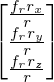

In [99]:
# f(r)をベクトルrで微分する。
f_r, r_x, r_y, r_z = symbols('f_r, r_x, r_y, r_z')
r = Matrix(3,1,[r_x,r_y,r_z])
r_2 = r_x**2 + r_y**2 + r_z**2
D = diff(sqrt(r_2), r) * f_r
Di = D.subs((r_x**2+r_y**2+r_z**2)**0.5,'r')
Di

In [61]:
def di(r, f_r):
    """
    粒子i,jの距離r = |r_i - r_j|の関数f(r)を、iの位置ベクトルr_iで一階微分する。
    f_r,は距離での一階微分
    答は3-ベクトル
    """
    return f_r*(r/np.linalg.norm(r))

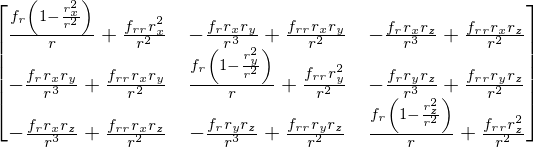

In [92]:
# f(r)をベクトルrで2回微分する。
f_rr = symbols('f_rr')
Dii = Matrix(3,3,diff(sqrt(r_2), r.T, r) * f_r)
Dii += diff(sqrt(r_2), r)*diff(sqrt(r_2), r).T * f_rr
Dii = Dii.subs((r_x**2+r_y**2+r_z**2)**0.5,'r')
Dii

In [93]:
# このあたりの関数も、できればsympyに生成させたい。
def dxixi(r, f_r, f_rr):
    # r is a vector
    rL2 = r@r
    rL = rL2**0.5
    return f_r*(1 - r**2 / rL2) / rL + f_rr*r**2 / rL2

def dxiyi(r, f_r, f_rr):
    # r is a vector
    rL2 = r@r
    rL = rL2**0.5
    yz = -f_r*r[1]*r[2]/(rL2*rL) + f_rr*r[1]*r[2]/rL2
    zx = -f_r*r[2]*r[0]/(rL2*rL) + f_rr*r[2]*r[0]/rL2
    xy = -f_r*r[0]*r[1]/(rL2*rL) + f_rr*r[0]*r[1]/rL2
    return yz,zx,xy

def dii(r, f_r, f_rr):
    """
    粒子i,jの距離r = |r_i - r_j|の関数f(r)を、iの位置ベクトルr_iで二階微分する。
    f_r, f_rrは距離での一階、二階微分
    答は3x3行列。
    """
    H = np.zeros((3,3))
    vxx,vyy,vzz = dxixi(r, f_r, f_rr)
    H[0,0] += vxx
    H[1,1] += vyy
    H[2,2] += vzz

    vyz,vzx,vxy = dxiyi(r, f_r, f_rr)
    H[0,1] += vxy
    H[1,2] += vyz
    H[0,2] += vzx
    H[1,0] += vxy
    H[2,1] += vyz
    H[2,0] += vzx
    return H

In [94]:
# 相互作用関数の距離での微分はsympyで自動生成する。
a1,a2,r = symbols('a1 a2 r')
F = 1/r
phic=lambdify([r], F)
phic_r=lambdify([r], diff(F,r))
phic_rr=lambdify([r], diff(F,r,r))
F = a1*r**(-12) - a2*r**(-6)
phiLJ=lambdify([r,a1,a2], F)
phiLJ_r=lambdify([r,a1,a2], diff(F,r))
phiLJ_rr=lambdify([r,a1,a2], diff(F,r,r))

rout = 8.5
trans = 2.0
rin  = rout - trans

x,y = symbols('x y')
# F0 is a truncation function ranged in [0,1]
F0 = -(x-1)**3*(6*x**2+3*x+1)
# 関数区間を変更
F = F0.subs(x,(y-rin)/trans)
# 解析的な微分を、数値関数に変換する

# Truncation function, raw
Trunc = lambdify([y], F)

# Truncation function, first derivative
Trunc_r = lambdify([y], diff(F,y))

# Truncation function, second derivative
Trunc_rr = lambdify([y], diff(F,y,y))

# Trunc(6.5), Trunc(8.5), Trunc_r(6.5), Trunc_r(8.5), Trunc_rr(6.5), Trunc_rr(8.5)

In [95]:
%%time
# 相互作用と分子形状に関するブロック


# 当面、田中プログラムとの照合のために、エネルギーの単位は、水素2原子が1 Aにいる時のCoulomb力を1とする。

# SI unit 2019
Na=6.02214076e23
ee=1.60217662e-19
E0=8.8541878128e-12
UJ = 4.184
qe0 = ee**2/(4*math.pi*E0)*Na/UJ*1e7
qeT = 332.17752e0
sw = (qeT*UJ*1e6/18.0)**0.5/(6.0*math.pi)
# Tanaka's Units
TanakaScale = qeT / qe0
TokJmol = ee**2/(4*math.pi*E0*1e-7)*Na*TanakaScale
print("TanakaScale", TanakaScale)

# 質点の質量
mass = np.array([wh,wh,wo,0.0])

I = np.array([[mass @ np.sum(intra[1:3]**2, axis=0),
               mass @ np.sum(intra[0:3:2]**2, axis=0),
               mass @ np.sum(intra[0:2]**2, axis=0)],
              [mass @ np.sum(intra2[1:3]**2, axis=0),
               mass @ np.sum(intra2[0:3:2]**2, axis=0),
               mass @ np.sum(intra2[0:2]**2, axis=0)]])

charge = [0.52,0.52,0,-1.04]
LJpairs = {(2, 2):(6.0e5*UJ / TokJmol, 6.10e2*UJ / TokJmol)}
CCpairs = dict()
for i,ci in enumerate(charge):
    for j,cj in enumerate(charge):
        cc = ci*cj
        if cc:
            CCpairs[i,j] = cc
            


TanakaScale 1.0003427429781058
CPU times: user 276 µs, sys: 108 µs, total: 384 µs
Wall time: 333 µs


In [96]:
def Hessian_tt(phis, trunc):
    """
    Trans-Trans Hessian for a pair of molecules
    """
    H = np.zeros([3,3])
    for (si,sj),(r, (phi, phi_r, phi_rr)) in phis.items():
        h = dii(r, phi_r, phi_rr)
        #print("sdxx",si,sj,h[0,0]/0.52**2)
        #print("ri",1/np.linalg.norm(r))
        if trunc:
            #print("ramp",ramp, Tvv)
            v, vL, ramp, ramp_r, ramp_rr, Tv, Tvv = trunc 
            rL = np.linalg.norm(r)
            h = ramp*h + Tvv*phi
            h += ramp_r*phi_r/(vL*rL) * (np.outer(r,v)+np.outer(v,r))
            #print("OUTER",(np.outer(r,v)+np.outer(v,r))/(vL*rL))
        H += h
    Htt = np.zeros([2,3,2,3])
    Htt[0, :, 0, :] = H
    Htt[1, :, 1, :] = H
    Htt[0, :, 1, :] = -H
    Htt[1, :, 0, :] = -H
    # print(im,jm,Htt)
    return Htt


def Hessian_rr(phis, D1i, D2i, D1j, D2j, ramp):
    Hrr = np.zeros([2,3,2,3])
    for (i,j),(r, (phi, phi_r, phi_rr)) in phis.items():
        rL = np.linalg.norm(r)

        # 式の導出はDerivative.ipynbを参照
        # **3 同じ分子の異なる角度変数の組みあわせ
        for d1 in range(3):
            for d2 in range(d1,3):
                h = (phi_r/rL**3*(rL**2 * (r @ D2i[d1,d2,:,i] + D1i[d1,:,i] @ D1i[d2,:,i]) -
                                                      (r @ D1i[d1,:,i])*(r @ D1i[d2,:,i])) +
                                         phi_rr/rL**2*(r @ D1i[d1,:,i])*(r @ D1i[d2,:,i]))
                Hrr[0,d1,0,d2] += h*ramp
                h = (phi_r/rL**3*(rL**2 * (-r @ D2j[d1,d2,:,j] + D1j[d1,:,j] @ D1j[d2,:,j]) -
                                                      (r @ D1j[d1,:,j])*(r @ D1j[d2,:,j])) +
                                         phi_rr/rL**2*(r @ D1j[d1,:,j])*(r @ D1j[d2,:,j]))
                Hrr[1,d1,1,d2] += h*ramp
        # **4 異なる分子の角度変数の組みあわせ
        for id in range(3):
            for jd in range(3):
                h = -(phi_r/rL**3*(rL**2 * (D1i[id,:,i] @ D1j[jd,:,j]) -
                                                       (r @ D1i[id,:,i])*(r @ D1j[jd,:,j])) +
                                          phi_rr/rL**2*(r @ D1i[id,:,i])*(r @ D1j[jd,:,j]))
                Hrr[0,id,1,jd] += h*ramp
        # 下半分はあとでコピーすればいい。
    # Hrrを一旦3nmol x 3nmolの平たい上半行列に戻し、
    Hrr = Hrr.reshape(6,6)
    # 対称化し、
    Hrr = Hrr + Hrr.T - np.diag(Hrr.diagonal())
    # また行列の配列に戻す。
    Hrr = Hrr.reshape(2,3,2,3)
    return Hrr


def Hessian_tr(phis, D1i, D1j, ramp, Tv):
    """
    Trans-Rot Hessian for a pair of molecules
    """
    Htr = np.zeros([2,3,2,3])
    for (i,j),(r, (phi, phi_r, phi_rr)) in phis.items():
        rL = np.linalg.norm(r)

        # **5 同じ分子
        for it in range(3):
            for ir in range(3):
                h = (phi_r/rL**3 * (rL**2*D1i[ir,it,i] - r[it]*(r @ D1i[ir,:,i])) +
                                          phi_rr/rL**2 * r[it]*(r @ D1i[ir,:,i]))
                if ramp != 1.0:
                    h = ramp*h + Tv[it]*phi_r/rL*(r @ D1i[ir,:,i])
                Htr[0,it,0,ir] += h
        for jt in range(3):
            for jr in range(3):
                h = (phi_r/rL**3 * (rL**2*D1j[jr,jt,j] - r[jt]*(r @ D1j[jr,:,j])) +
                                          phi_rr/rL**2 * r[jt]*(r @ D1j[jr,:,j]))
                if ramp != 1.0:
                    h = ramp*h + Tv[jt]*phi_r/rL*(r @ D1j[jr,:,j])
                Htr[1,jt,1,jr] += h
        # **6 異なる分子
        for it in range(3):
            for jr in range(3):
                h = (phi_r/rL**3 * (rL**2*D1j[jr,it,j] - r[it]*(r @ D1j[jr,:,j])) +
                                          phi_rr/rL**2 * r[it]*(r @ D1j[jr,:,j]))
                if ramp != 1.0:
                    h = ramp*h + Tv[it]*phi_r/rL*(r @ D1j[jr,:,j])
                Htr[0,it,1,jr] -= h
        for jt in range(3):
            for ir in range(3):
                h = (phi_r/rL**3 * (rL**2*D1i[ir,jt,i] + r[jt]*(-r @ D1i[ir,:,i])) +
                                          phi_rr/rL**2 * -r[jt]*(-r @ D1i[ir,:,i]))
                if ramp != 1.0:
                    h = ramp*h + Tv[jt]*phi_r/rL*(r @ D1i[ir,:,i])
                Htr[1,jt,0,ir] -= h
    return Htr

def E_pair(phis, ramp):
    ep = 0.0
    for (si,sj),(r, (phi, phi_r, phi_rr)) in phis.items():
        ep += ramp*phi
    return ep



In [97]:
%%time
import itertools as itt

## Hessianの計算。もっと小さい関数に分けたいが、かなり手強い。

# 3x3行列の配列。
Htt = np.zeros([nmol, 3, nmol, 3])
Hrr = np.zeros([nmol, 3, nmol, 3])
Htr = np.zeros([nmol, 3, nmol, 3])

ep = 0
for im in range(nmol):
    for jm in range(im+1,nmol):
        # 重心間相対ベクトル
        v = pos[im][:3] - pos[jm][:3]
        v -= cell @ np.floor( celli @ v + 0.5 )
        # 重心間距離
        vL = np.linalg.norm(v)
        # print("vL",vL)
        
        # 切断関数を準備。
        trunc = False
        if vL > rout:
            # 遠すぎる対はパス
            continue
        if vL > rin:
            # カットオフ関数がかかる場合
            ramp = Trunc(vL)
            ramp_r = Trunc_r(vL)
            ramp_rr = Trunc_rr(vL)
            # Tのvによる一階微分(ベクトル)
            Tv = di(v, ramp_r)
            # Truncのvによる二階微分(テンソル)
            Tvv = dii(v, ramp_r, ramp_rr)
            trunc = v, vL, ramp, ramp_r, ramp_rr, Tv, Tvv
        else:
            # 近距離
            ramp = 1.0

        # サイト間の相互作用関数の、相対位置ベクトルによる多階微分をあらかじめ配列phisに入れておく。
        phis = dict()
        
        for (i,j),cc in CCpairs.items():
            r = D0[im,:,i] - D0[jm,:,j] + v
            if (i,j) not in phis:
                phis[i,j] = [r, np.zeros(3)]
            rL = np.linalg.norm(r)
            phi    = cc*phic(rL)
            phi_r  = cc*phic_r(rL)
            phi_rr = cc*phic_rr(rL)
            phis[i,j][1] += np.array([phi, phi_r, phi_rr])

        for (i,j),(a1,a2) in LJpairs.items():
            r = D0[im,:,i] - D0[jm,:,j] + v
            if (i,j) not in phis:
                phis[i,j] = [r, np.zeros(3)]
            rL = np.linalg.norm(r)
            phi    = phiLJ(rL,a1,a2)
            phi_r  = phiLJ_r(rL,a1,a2)
            phi_rr = phiLJ_rr(rL,a1,a2)
            phis[i,j][1] += np.array([phi, phi_r, phi_rr])

        # Check EP again
        ep += E_pair(phis, ramp)

        # 並進・並進
        Htt0 = Hessian_tt(phis, trunc)
        Htt[im, :, im, :] += Htt0[0, : , 0, :]
        Htt[jm, :, jm, :] += Htt0[1, : , 1, :]
        Htt[im, :, jm, :] += Htt0[0, : , 1, :]
        Htt[jm, :, im, :] += Htt0[1, : , 0, :]

        # 次は回転・回転
        Hrr0 = Hessian_rr(phis, D1[im], D2[im], D1[jm], D2[jm], ramp)
        Hrr[im, :, im, :] += Hrr0[0, : , 0, :]
        Hrr[jm, :, jm, :] += Hrr0[1, : , 1, :]
        Hrr[im, :, jm, :] += Hrr0[0, : , 1, :]
        Hrr[jm, :, im, :] += Hrr0[1, : , 0, :]

        # 最後に並進・回転
        Htr0 = Hessian_tr(phis, D1[im], D1[jm], ramp, Tv)
        Htr[im, :, im, :] += Htr0[0, : , 0, :]
        Htr[jm, :, jm, :] += Htr0[1, : , 1, :]
        Htr[im, :, jm, :] += Htr0[0, : , 1, :]
        Htr[jm, :, im, :] += Htr0[1, : , 0, :]
print("energy (kJ/mol)=",ep*TokJmol/nmol)


np.set_printoptions(4)



# ***1 謎のテンソルの計算
eival = np.zeros([nmol,3])
eivec = np.zeros([nmol,3,3])

for i in range(nmol):
    # 分子内座標での慣性テンソル
    Ii = I[lc[i]] / wm
# wmで割ることで、並進には質量を掛ける必要がなくなる。
# verified rix, riy,riz

    ea,eb,ec = pos[i][3:6]
    sina = math.sin(ea)
    cosa = math.cos(ea)
    sinb = math.sin(eb)
    cosb = math.cos(eb)
    sinc = math.sin(ec)
    cosc = math.cos(ec)
    ev = np.array([[Ii[0]*cosc**2 + Ii[1]*sinc**2, (Ii[0]-Ii[1])*sina*sinc*cosc, 0.0],
                   [(Ii[0]-Ii[1])*sina*sinc*cosc,  (Ii[0]*sinc**2+Ii[1]*cosc**2)*sina**2+Ii[2]*cosa**2, Ii[2]*cosa],
                   [0.0,  Ii[2]*cosa, Ii[2]]])
    #print("***6")
    #print(ev)
    # ev verified
    ival, ivec = np.linalg.eig(ev)
    idx = np.argsort(-ival)
    ival = ival[idx]
    ivec = ivec[:,idx]
    eival[i] = 1/ival**0.5
    eivec[i] = ivec
    # eig verified
    #print("eival")
    #print(eival[i])
    #print("eivec")
    #print(eivec[i])

# rot-rot
for i in range(nmol):
    for j in range(nmol):
        # elements of rot-rot
        t = Hrr[j,:,i,:]
        #print("***4",i,j)
        #print(t)
        t = eivec[j].T @ t @ eivec[i]
        sd = t * np.outer(eival[j],eival[i])
        Hrr[j,:,i,:] = sd
        #print("***5",i,j)
        #print(sd)
        #print()

# rot-trans
for i in range(nmol):
    for j in range(nmol):
        # elements of trans-rot
        t = Htr[i,:,j,:].T
        #print("***7")
        #print(t)
        t = Htr[i,:,j,:]
        t = t @ eivec[j]
        sd = t * eival[j]
        Htr[i,:,j,:] = sd
        #print("***8")
        #print(sd)
        #print()

Hessian = np.zeros([6*nmol, 6*nmol])
Hessian[0*nmol:3*nmol,0*nmol:3*nmol] = Htt.reshape(3*nmol,3*nmol)
Hessian[3*nmol:6*nmol,3*nmol:6*nmol] = Hrr.reshape(3*nmol,3*nmol)
Hessian[0*nmol:3*nmol,3*nmol:6*nmol] = Htr.reshape(3*nmol,3*nmol)
Hessian[3*nmol:6*nmol,0*nmol:3*nmol] = Htr.reshape(3*nmol,3*nmol).T

np.set_printoptions(4)

#print(Hessian/0.52**2)

# 系が小さい場合には、圧倒的にここが遅い。

energy (kJ/mol)= 0.03884210006881554
CPU times: user 10.2 ms, sys: 3.33 ms, total: 13.6 ms
Wall time: 11.2 ms


In [98]:
%%time
ival, ivec = np.linalg.eigh(Hessian)

for iv in sorted(ival,reverse=True):
    if iv > 0:
        iv = iv**0.5 * sw
    else:
        iv = -(-iv)**0.5 * sw
    print(iv)


95.18011714359442
44.2507979270288
27.18980399678063
9.887632752525014e-07
5.754626750024179e-07
-6.564139209932475e-07
-3.2567213126119707
-7.482131380620787
-28.6285571437099
-37.195860241136856
-50.656183591544234
-72.48723707456553
CPU times: user 1.11 ms, sys: 1.01 ms, total: 2.12 ms
Wall time: 1.12 ms


## 完了
* 第二回転規準
   * 全部第二規準にすると、全部第二規準とした田中プログラムと同じ答えになることを確認。
   * 一方で、田中プログラム自体、規準を変更すると振動数が変わるのがとても気になる。
   * 回転行列を二種類準備する代わりに、分子内座標を2種類準備することにした。
     * xyz→yzxに変えるようにした。
     * 角度変換規則(euler_conv)は田中のものと結果的には同じであった。たぶん発想は同じ。
     * その場合でも、振動数が微妙に変化する。変化のしかたも同様なので、同じことをやっているにすぎないと思われる。
     * ということは、分子内座標で、分子をどういう向きに置くかによって、結果が変わるということ。
     * Hessianの計算に関しては、あまり疑う余地がないので、mass weightのあたりしか考えられないのだが…。
     * Quenchしてあれば問題がおきないということで合意。Quenchしない場合に変になる理由はわからない。
* LJ
* 多分子
* 周期境界条件
* Truncation
* 特殊な単位系の廃止
* 小さい系(CS2)であれば、現実的な速度で正確な振動を得ることができた。2019-09-26
* 整理し、読みやすくする。

## 未完
* Hessianの式の自動生成

## 別計画

* 数値微分によるHessian計算はどれぐらい現実味があるのか。
   * このプログラムがうまく動くことが確認できれば、比較対象に使える。 


In [ ]:
intra

In [ ]:
intra[1:3] * intra[1:3]

In [ ]:
np.sum(intra[1:3]**2, axis=0) @ mass

In [ ]:
np.outer(np.array([1,2,3]),np.array([1,2,3]))

In [ ]:
np.diag(np.array([1,1,1]))

In [121]:
np.cross(np.array([1,2,3]),np.array([1,2,3]))

array([0, 0, 0])